# Put TNG data into format for cosmic integration with COMPAS

Cosmic integration in COMPAS currently uses analytical model for SFR (M&D 14) and for the metallicity distribution (skewed log normal, based on Neijssel+ 19). There are 4 SFR parameters and 5 dP/dlogZ parameters.

The SFR is calculated using the find_sfr function, which needs the redshifts as a list of floats at which the SFR will be evaluated, and the 4 parameters a,b,c,d. The SFR is then returned as a list of floats (corresponding to each redshift), in units of M_$\odot$/Gpc$^3$/yr.

The metallicity distribution (dP/dlogZ) is calculated using the find_metallicity_distribution function which needs both COMPAS information, the metallicity distribution parameters ($\mu_0, \mu_z, \omega_0, \omega_z, \alpha$), the redshifts as a list of floats, and minimum and maximum logZ and the step size in logZ. 
- The metallicities at which dP/dlogZ is calculated at is calculated from the min, max, and step size of logZ. Then take the exponent to get the metallicities which are returned. dP/dlogZ is calculated using logZ. 
- The list of redshifts is used to calculate the mean metallicities and the log-Linear redshift dependence of sigma. When using the model, the mean metallicities ($\mu$) are calculated from $\mu_0$ and $\mu_z$ and the variance ($\omega$) is calculated from $\omega_0$ and $\omega_z$.

In [903]:
import sys
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import seaborn as sns

from scipy import interpolate
from astropy.cosmology import Planck15  as cosmo# Planck15 since that's what TNG uses
from astropy.cosmology import z_at_value
from IPython.display import Image # to open images in Ipython 
from scipy.stats import norm as NormDist

############################
# Custom scripts
sys.path.append('../')
import get_ZdepSFRD as Z_SFRD
import importlib
import paths

In [904]:
#Change file names to match TNG version
tng=100
ver = 1
Cosmol_sim_location = paths.data / str("SFRMetallicityFromGasTNG%s-%s.hdf5"%(tng,ver))
fit_filename = 'test_best_fit_parameters_TNG%s-%s.txt'%(tng,ver)
if tng==50:
    rbox=35
elif tng==100:
    rbox=75
elif tng==300:
    rbox=205
SFRD_Z_z_fname = 'SFRD_TNG%s-%s.txt'%(tng,ver)
metals_fname = 'metallicities_TNG.txt'
Zsun = 0.014 # Solar metallicity
cmap = sns.color_palette('rocket', as_cmap=True)

In [905]:
def find_sfr(redshifts, a = 0.01, b =2.77, c = 2.90, d = 4.70):
    # get value in mass per year per cubic Mpc and convert to per cubic Gpc then return
    sfr = a * ((1+redshifts)**b) / (1 + ((1+redshifts)/c)**d) * u.Msun / u.yr / u.Mpc**3
    return sfr.to(u.Msun / u.yr / u.Gpc**3).value

In [955]:
def find_metallicity_distribution(redshifts, metals = [], min_logZ_COMPAS = np.log(1e-4), max_logZ_COMPAS = np.log(0.03),
                                  mu_0=0.025, mu_z=-0.048, sigma_0=1.125, sigma_z=0.048, alpha =-1.767,
                                  min_logZ=-12.0, max_logZ=0.0, step_logZ =0.01):
    # Log-Linear redshift dependence of sigma
    sigma = sigma_0* 10**(sigma_z*redshifts)

    # Follow Langer & Norman 2007? in assuming that mean metallicities evolve in z as:
    mean_metallicities = mu0 * 10**(muz * redshifts)

    # Now we re-write the expected value of ou log-skew-normal to retrieve mu
    beta = alpha/(np.sqrt(1 + (alpha)**2))
    PHI  = NormDist.cdf(beta * sigma)
    mu_metallicities = np.log(mean_metallicities/(2.*PHI)) - (sigma**2)/2.
    
    if len(metals) == 0:
        # create a range of metallicities (thex-values, or raandom variables)
        log_metallicities = np.arange(min_logZ, max_logZ + step_logZ, step_logZ)
        metallicities     = np.exp(log_metallicities)
    else: 
        #use a pre-determined array of metals
        metallicities     = metals
        log_metallicities = np.log(metallicities)
        step_logZ         = np.diff(log_metallicities)[0]
        
    # probabilities of log-skew-normal (without the factor of 1/Z since this is dp/dlogZ not dp/dZ)
    dPdlogZ = 2./(sigma[:,np.newaxis]) \
    * NormDist.pdf((log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis]) \
    * NormDist.cdf(alpha * (log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis] )

    # normalise the distribution over all metallicities
    norm = dPdlogZ.sum(axis=-1) * step_logZ
    dPdlogZ = dPdlogZ /norm[:,np.newaxis]

    # assume a flat in log distribution in metallicity to find probability of drawing Z in COMPAS
    p_draw_metallicity = 1 / (max_logZ_COMPAS - min_logZ_COMPAS)
    
    return dPdlogZ, metallicities, step_logZ, p_draw_metallicity

### Read TNG data

In [907]:
Sim_SFRD, Lookbacktimes, Sim_center_Zbin, step_fit_logZ, Redshifts = read.load_TNG(loc = Cosmol_sim_location, rbox=rbox)

In [908]:
minZ_popSynth    =  1e-6
# Adjust what metallicities to include 
tofit_Sim_metals = Sim_center_Zbin[np.where(Sim_center_Zbin > minZ_popSynth)[0]]   

# Reverse the time axis of the SFRD and lookback time for the fit
tofit_Sim_SFRD      = Sim_SFRD[:,np.where(Sim_center_Zbin > minZ_popSynth)[0]][::-1]
tofit_Sim_lookbackt = Lookbacktimes[::-1] 

# Get redshifts
redshifts_Sim = Redshifts

In [910]:
Sim_center_Zbin

array([1.23389963e-10, 1.81111698e-10, 2.65835618e-10, 3.90193325e-10,
       5.72725476e-10, 8.40646035e-10, 1.23389963e-09, 1.81111698e-09,
       2.65835618e-09, 3.90193325e-09, 5.72725476e-09, 8.40646035e-09,
       1.23389963e-08, 1.81111698e-08, 2.65835618e-08, 3.90193325e-08,
       5.72725476e-08, 8.40646035e-08, 1.23389963e-07, 1.81111698e-07,
       2.65835618e-07, 3.90193325e-07, 5.72725476e-07, 8.40646035e-07,
       1.23389963e-06, 1.81111698e-06, 2.65835618e-06, 3.90193325e-06,
       5.72725476e-06, 8.40646035e-06, 1.23389963e-05, 1.81111698e-05,
       2.65835618e-05, 3.90193325e-05, 5.72725476e-05, 8.40646035e-05,
       1.23389963e-04, 1.81111698e-04, 2.65835618e-04, 3.90193325e-04,
       5.72725476e-04, 8.40646035e-04, 1.23389963e-03, 1.81111698e-03,
       2.65835618e-03, 3.90193325e-03, 5.72725476e-03, 8.40646035e-03,
       1.23389963e-02, 1.81111698e-02, 2.65835618e-02, 3.90193325e-02,
       5.72725476e-02, 8.40646035e-02, 1.23389963e-01, 1.81111698e-01,
      

In [911]:
# Interpolate the simulation data
f_interp = interpolate.interp2d(tofit_Sim_lookbackt, tofit_Sim_metals, tofit_Sim_SFRD.T, kind='cubic')

# Retrieve values at higher res regular intervals
redshift_new         = np.arange(0, 10.1, 0.05) #202 redshift values
Lookbacktimes_new    = [cosmo.lookback_time(z).value for z in redshift_new]

log_tofit_Sim_metals = np.log10(tofit_Sim_metals)
metals_new           = np.logspace(min(log_tofit_Sim_metals), max(log_tofit_Sim_metals), 500) #500 metal values

SFRDnew = f_interp(Lookbacktimes_new,metals_new)
SFRDnew[SFRDnew < 0] = 0 #make sure there are no unphysical values of the SFRD

In [912]:
# read best fit data (for comparison)
mu0, muz, omega0, omegaz, alpha, sf_a, sf_b, sf_c, sf_d = np.loadtxt(str(paths.data)+'/'+fit_filename,unpack=True, delimiter=',')

In [913]:
dPdlogZ, metallicities, step_logZ, p_draw_metallicity = find_metallicity_distribution(redshift_new, metals = metals_new,
                                  mu_0=mu0, mu_z=muz, sigma_0=omega0, sigma_z=omegaz, alpha =alpha,
                                  min_logZ=-12.0, max_logZ=0.0, step_logZ =0.01)

0.026917327406412284


In [918]:
sfr = find_sfr(redshift_new, a=sf_a, b=sf_b, c=sf_c, d=sf_d)

In [920]:
SFR = np.sum(SFRDnew,axis=0)

In [922]:
with h5.File(Cosmol_sim_location, "r") as f:
        MetalBins     = f["MetalBins"][:]
        Lookbacktimes = f["Lookbacktimes"][:]
        BoxSfr        = f["Sfr"][:]
        Redshifts_TNG     = f["Redshifts"][:]
# Convert SFR from sfr/box to sfr Mpc-3
littleh  = 0.6774
Rbox     = rbox/littleh
TNG_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
TNG_SFRD = TNG_SFRD.value
redshifts_TNG = Redshifts_TNG

print(TNG_SFRD.shape, len(redshifts_TNG), np.sum(TNG_SFRD,axis=1).shape)

(100, 60) 100 (100,)


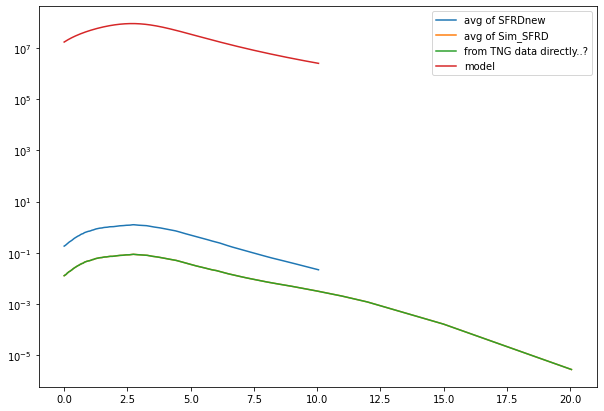

In [923]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

plt.plot(redshift_new, np.sum(SFRDnew*step_fit_logZ,axis=0), label='avg of SFRDnew')
plt.plot(Redshifts, np.sum(Sim_SFRD*step_fit_logZ, axis=1), label='avg of Sim_SFRD')
plt.plot(redshifts_TNG, np.sum(TNG_SFRD, axis=1), label='from TNG data directly..?')
plt.plot(redshift_new, sfr, label='model')
plt.yscale('log')
plt.legend();

## Write SFRD(Z, z) data to files

In [924]:
# Interpolate the simulation data
f_interp = interpolate.interp2d(tofit_Sim_lookbackt, tofit_Sim_metals, tofit_Sim_SFRD.T, kind='cubic')

# Retrieve values at higher res regular intervals
redshift_COMPAS         = np.arange(0, 14.05, 0.05)
Lookbacktimes_COMPAS    = [cosmo.lookback_time(z).value for z in redshift_COMPAS]

log_tofit_Sim_metals = np.log10(tofit_Sim_metals)
metals_new           = np.logspace(min(log_tofit_Sim_metals), max(log_tofit_Sim_metals), 500) #500 metal values
log_metallicities_c = np.arange(-6, 0 + step_logZ, 0.01)
metallicities_c = 10**(log_metallicities_c)

SFRD_COMPAS = f_interp(Lookbacktimes_COMPAS,metals_new)
SFRD_COMPAS[SFRD_COMPAS < 0] = 0 #make sure there are no unphysical values of the SFRD

In [925]:
# Read out data
np.savetxt(SFRD_Z_z_fname, SFRD_COMPAS)
np.savetxt(metals_fname, metals_new)

In [926]:
# Check whether can read in data correctly
SFRD_Z_z_test = np.loadtxt(SFRD_Z_z_fname)
metallicities_test = np.loadtxt(metals_fname)

In [927]:
np.where((SFRD_Z_z_test == SFRD_COMPAS) == False)

(array([], dtype=int64), array([], dtype=int64))

In [928]:
SFRD_Z_z_test.shape

(500, 281)

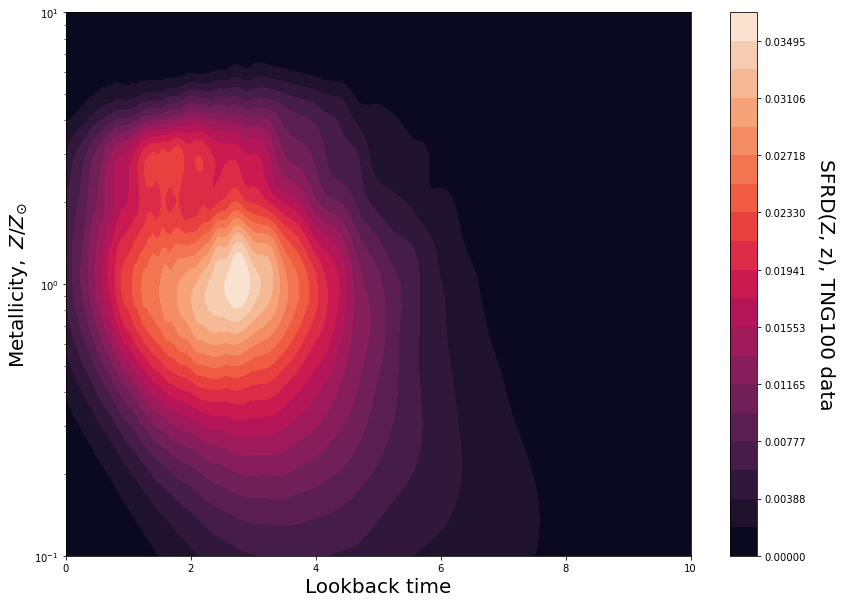

In [929]:
fig, ax = plt.subplots(figsize = (14,10))

levels = np.linspace(np.amin(SFRD_Z_z_test), np.amax(SFRD_Z_z_test), 20)
#levels = np.linspace(0, 0.055, 20)

data = ax.contourf(redshift_COMPAS, metallicities_test/Zsun, SFRD_Z_z_test, levels=levels, cmap=cmap)

ax.set_yscale('log')
ax.set_xlabel('Lookback time', fontsize=20)
ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize=20)
ax.set_ylim(10**-1, 10**1)
ax.set_xlim(0, 10)

"""
ax2 = ax.twiny()
redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10,14]
ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
ax2.set_xlabel('Redshift', fontsize = 20)
ax.set_xlim(min(Lookbacktimes_COMPAS), max(Lookbacktimes_COMPAS))
ax2.set_xlim(min(Lookbacktimes_COMPAS), max(Lookbacktimes_COMPAS))
"""

cbar = fig.colorbar(data)
if ver>1:
    cbar.set_label('SFRD(Z, z), TNG%s-%s data'%(tng, ver), rotation=270, fontsize=20, labelpad=30);
else:
    cbar.set_label('SFRD(Z, z), TNG%s data'%tng, rotation=270, fontsize=20, labelpad=30);

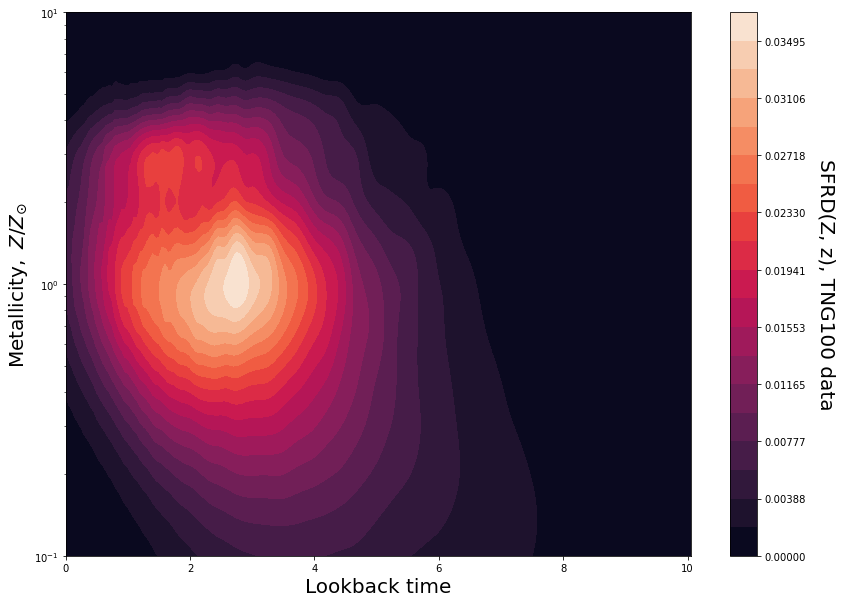

In [930]:
fig, ax = plt.subplots(figsize = (14,10))

levels = np.linspace(np.amin(SFRDnew), np.amax(SFRDnew), 20)
#levels = np.linspace(0, 0.055, 20)

data = ax.contourf(redshift_new, metals_new/Zsun, SFRDnew, levels=levels, cmap=cmap)

ax.set_yscale('log')
ax.set_xlabel('Lookback time', fontsize=20)
ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize=20)
ax.set_ylim(10**-1, 10**1)

"""
ax2 = ax.twiny()
redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10,14]
ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
ax2.set_xlabel('Redshift', fontsize = 20)
ax.set_xlim(min(Lookbacktimes_COMPAS), max(Lookbacktimes_COMPAS))
ax2.set_xlim(min(Lookbacktimes_COMPAS), max(Lookbacktimes_COMPAS))
"""

cbar = fig.colorbar(data)
if ver>1:
    cbar.set_label('SFRD(Z, z), TNG%s-%s data'%(tng, ver), rotation=270, fontsize=20, labelpad=30);
else:
    cbar.set_label('SFRD(Z, z), TNG%s data'%tng, rotation=270, fontsize=20, labelpad=30);

In [931]:
# Get the SFR (Shape of Madau & Fragos 2014)
sfr = Z_SFRD.Madau_Dickinson2014(redshift_new, a=sf_a, b=sf_b, c=sf_c, d=sf_d).value # Msun year-1 Mpc-3 
# Get dPdZ (skew-log-normal distribution)
dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                    Z_SFRD.skew_metallicity_distribution(redshift_new ,mu_z = muz , mu_0 = mu0 ,
                                                  omega_0= omega0 , omega_z=omegaz , alpha = alpha , 
                                                  metals=metals_new)
    

model = sfr[:,np.newaxis] * dPdlogZ

In [932]:
model

array([[2.22691559e-21, 2.78403879e-21, 3.47852502e-21, ...,
        3.68973636e-10, 2.80171884e-10, 2.12247847e-10],
       [4.03503838e-21, 5.03121953e-21, 6.26974757e-21, ...,
        4.49292146e-10, 3.42075419e-10, 2.59846071e-10],
       [7.24027870e-21, 9.00426752e-21, 1.11916862e-20, ...,
        5.44636001e-10, 4.15768481e-10, 3.16671955e-10],
       ...,
       [2.63655801e-05, 2.68758715e-05, 2.73944185e-05, ...,
        2.35788917e-06, 2.25017704e-06, 2.14689935e-06],
       [2.69671789e-05, 2.74820417e-05, 2.80050962e-05, ...,
        2.33392666e-06, 2.22807065e-06, 2.12653993e-06],
       [2.75697480e-05, 2.80889699e-05, 2.86163154e-05, ...,
        2.30988251e-06, 2.20586310e-06, 2.10606213e-06]])

In [933]:
nformed = sfr/0.13123123123
model2 = nformed[:,np.newaxis] * dPdlogZ

## dPdlogZ

In [934]:
TNG = 100
lvl = 1

In [935]:
with h5.File(paths.data / str("SFRMetallicityFromGasWithMetalsTNG%s-%s.hdf5"%(TNG,lvl)), "r") as f:
        MetalBins     = f["MetalBins"][:]
        Lookbacktimes = f["Lookbacktimes"][:]
        BoxSfr        = f["Sfr"][:]
        Redshifts     = f["Redshifts"][:]
        Metals        = f["Metals"][:]

Sim_center_Zbin  = (MetalBins[:-1] + MetalBins[1:])/2.

# Convert SFR from sfr/box to sfr Mpc-3
littleh  = 0.6774
Rbox     = rbox/littleh
Sim_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
Sim_SFRD = Sim_SFRD.value

# The model comes in SFRD/DeltaZ, make sure your data does as well!! 
step_fit_logZ  = np.diff(np.log(MetalBins))[0]    
Sim_SFRD       = Sim_SFRD/step_fit_logZ

In [936]:
from colour import Color
blue = Color("blue")
colors = list(blue.range_to(Color("green"),100))
for i, val in enumerate(colors):
    colors[i] = str(val)

In [938]:
Redshifts

array([2.00464910e+01, 1.49891732e+01, 1.19802133e+01, 1.09756433e+01,
       9.99659047e+00, 9.38877127e+00, 9.00233985e+00, 8.44947629e+00,
       8.01217295e+00, 7.59510715e+00, 7.23627607e+00, 7.00541705e+00,
       6.49159775e+00, 6.01075740e+00, 5.84661375e+00, 5.52976581e+00,
       5.22758097e+00, 4.99593347e+00, 4.66451770e+00, 4.42803374e+00,
       4.17683491e+00, 4.00794511e+00, 3.70877426e+00, 3.49086137e+00,
       3.28303306e+00, 3.00813107e+00, 2.89578501e+00, 2.73314262e+00,
       2.57729027e+00, 2.44422570e+00, 2.31611074e+00, 2.20792547e+00,
       2.10326965e+00, 2.00202814e+00, 1.90408954e+00, 1.82268925e+00,
       1.74357057e+00, 1.66666956e+00, 1.60423452e+00, 1.53123903e+00,
       1.49551217e+00, 1.41409822e+00, 1.35757667e+00, 1.30237846e+00,
       1.24847261e+00, 1.20625808e+00, 1.15460271e+00, 1.11415056e+00,
       1.07445789e+00, 1.03551045e+00, 9.97294226e-01, 9.50531352e-01,
       9.23000816e-01, 8.86896938e-01, 8.51470901e-01, 8.16709979e-01,
      

Text(0, 0.5, '# SF gas cells with $Z/Z_\\odot$')

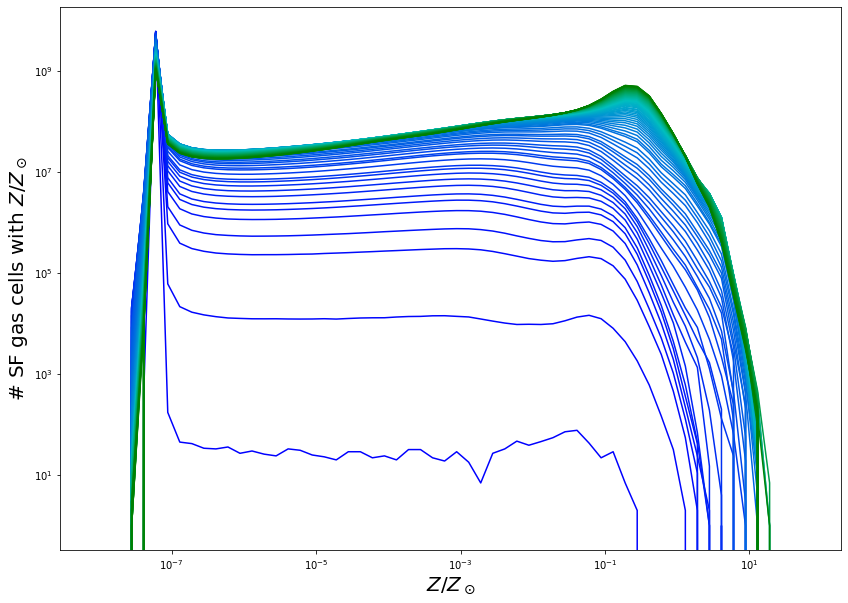

In [939]:
fig, ax = plt.subplots(figsize = (14,10))
for i in range(100):
    plt.plot(Sim_center_Zbin/Zsun, Metals[i], label='Snapshot %s' %i, c='%s'%colors[i])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$Z/Z_\odot$', fontsize=20)
plt.ylabel(r'# SF gas cells with $Z/Z_\odot$', fontsize=20)
#plt.legend();

Text(0, 0.5, 'Normalized # SF gas cells with $Z/Z_\\odot$')

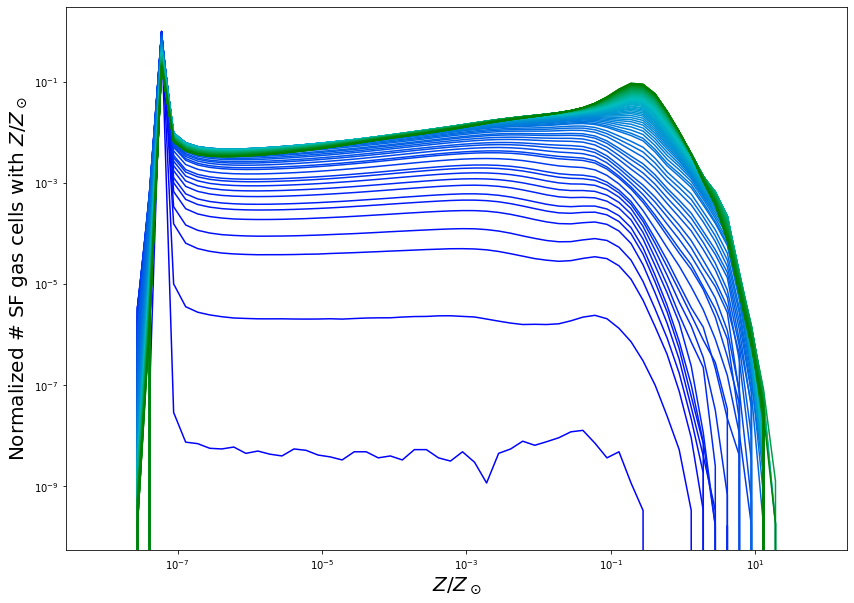

In [940]:
fig, ax = plt.subplots(figsize = (14,10))
totalZ = np.trapz(Metals)
for i in range(100):
    plt.plot(Sim_center_Zbin/Zsun, Metals[i]/totalZ[i], label='Snapshot %s' %i, c='%s'%colors[i])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$Z/Z_\odot$', fontsize=20)
plt.ylabel(r'Normalized # SF gas cells with $Z/Z_\odot$', fontsize=20)
#plt.legend();

In [941]:
#FROM COSMIC INT CALC OF SFR: get value in mass per year per cubic Mpc and convert to per cubic Gpc then return
#sfr = a * ((1+redshifts)**b) / (1 + ((1+redshifts)/c)**d) * u.Msun / u.yr / u.Mpc**3
#return sfr.to(u.Msun / u.yr / u.Gpc**3).value

# Convert SFR from sfr/box to sfr Mpc-3
littleh  = 0.6774
Rbox     = rbox/littleh
Sim_SFRD2 = BoxSfr / Rbox**3 *u.Mpc**-3
Sim_SFRD2 = Sim_SFRD2.value
Sim_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
Sim_SFRD = Sim_SFRD.value

# The model comes in SFRD/DeltaZ, make sure your data does as well <- do I want that too??
step_fit_logZ  = np.diff(np.log(MetalBins))[0]    
Sim_SFRD       = Sim_SFRD/step_fit_logZ

#NEED: Msun per year per cubic Gpc
#currently sfr/box -> sfr per cubic Mpc; sfr = Msun per year already in TNG! just convert to per Gpc

In [942]:
gpc = 1*u.Gpc**3
mpc = gpc.to(u.Mpc**3).value

In [943]:
mpc

1000000000.0000002

In [944]:
Sim_SFRD = Sim_SFRD * mpc
Sim_SFRD2 = Sim_SFRD2 * mpc

In [945]:
Sim_SFRD2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [946]:
sfr = find_sfr(Redshifts, a=sf_a, b=sf_b, c=sf_c, d=sf_d)

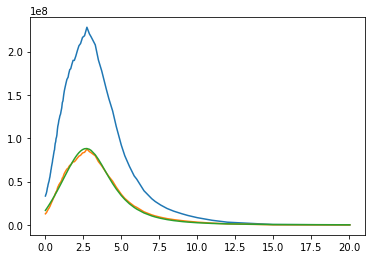

In [947]:
plt.plot(Redshifts, np.sum(Sim_SFRD, axis=1))
plt.plot(Redshifts, np.sum(Sim_SFRD2, axis=1))
plt.plot(Redshifts, sfr)

dPdlogZ: for each COMPAS binary, have the redshift at which the binary formed and the metallicity of that binary. Find the closest metallicity (bin center) in the TNG data to the COMPAS metallicity. At the redshift at which the binary formed, find the metallicity distribution from the TNG data. Calculate the probability of getting that TNG metallicity value. That is the dPdlogZ for that binary (but actually do all this with logZ)

Note that I should check if COMPAS metallicity is in Zsolar units

/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_83529/737669274.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(Sim_center_Zbin), np.log(Metals[30]))


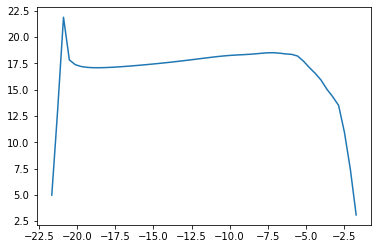

In [948]:
plt.plot(np.log(Sim_center_Zbin), np.log(Metals[30]))

In [949]:
np.log(Metals[30])

/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_83529/1706258063.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(Metals[30])


array([       -inf,        -inf,        -inf,  4.97673374, 13.05035597,
       21.89064336, 17.8338017 , 17.38344358, 17.2063904 , 17.12579649,
       17.09334434, 17.08784772, 17.10042297, 17.12419078, 17.15538107,
       17.19236583, 17.23370884, 17.27826424, 17.32535978, 17.37513688,
       17.42721967, 17.48147086, 17.53812399, 17.59737586, 17.65923903,
       17.72351022, 17.78938839, 17.85741145, 17.92666109, 17.99656856,
       18.0654278 , 18.13095504, 18.19062019, 18.24221809, 18.28197704,
       18.31265018, 18.34081262, 18.37510055, 18.42074956, 18.47297942,
       18.51287589, 18.51553396, 18.46672229, 18.40278457, 18.35841486,
       18.19972616, 17.7152023 , 17.10859776, 16.55951666, 15.91526244,
       15.04448598, 14.32828029, 13.50851926, 10.94284511,  7.45876269,
        3.09104245,        -inf,        -inf,        -inf,        -inf])

In [950]:
def calc_dPdlogZ(redshift_form, redshifts, binary_metallicity, data_metallicity, metallicity_dists, showdist=True):
    
    #find the redshift in the data that is the closest to the binary formation redshift
    z_ind = np.argmin(np.abs(redshifts - redshift_form)) #index
    z_form = redshifts[z_ind] #value of closest redshift 
    
    #convert everything to log metallicity
    binary_metallicity = np.log(binary_metallicity)
    data_metallicity = np.log(data_metallicity)
    metallicity_dists = np.log(metallicity_dists)
    metallicity_dists[metallicity_dists==-np.inf] = 0
    
    #find closest value in the metallicities in the data to the binary metallicity
    metallicity_ind = np.argmin(np.abs(data_metallicity - binary_metallicity)) #index
    metallicity_form = data_metallicity[metallicity_ind] #value of closest metallicity
    
    #find the probability of getting that metallicity using the metallicity distribution at this redshift
    metal_dist_form = metallicity_dists[z_ind, :]
    norm_metal_dist_form = metal_dist_form/np.trapz(metal_dist_form)
    
    if showdist==True:
        plt.plot(data_metallicity, norm_metal_dist_form) #plot just to check
        #plt.xscale('log')
        plt.yscale('log')
        plt.show()
    
    total=0 #just to double check
    for i in norm_metal_dist_form:
        total += i
    
    return(z_form, metallicity_form, norm_metal_dist_form[metallicity_ind], total) 

In [980]:
def calc_dPdlogZ_v2(redshift_form, redshifts, binary_metallicity, data_metallicity, metallicity_dists, showdist=True):
    
    dPdlogZs = []
    metals_form = []
    
    for z_ind, z in enumerate(redshifts):

        #convert everything to log metallicity
        #binary_metallicity = np.log(binary_metallicity)
        #data_metallicity = np.log(data_metallicity)
        #metallicity_dists = np.log(metallicity_dists)
        #metallicity_dists[metallicity_dists==-np.inf] = 0
    
        #find closest value in the metallicities in the data to the binary metallicity
        metallicity_ind = np.argmin(np.abs(data_metallicity - binary_metallicity)) #index
        metallicity_form = data_metallicity[metallicity_ind] #value of closest metallicity
    
        #find the probability of getting that metallicity using the metallicity distribution at this redshift
        metal_dist_form = metallicity_dists[z_ind, :]
        norm_metal_dist_form = metal_dist_form/np.trapz(metal_dist_form)
        
        if showdist==True:
            plt.plot(data_metallicity, norm_metal_dist_form) #plot just to check
            plt.xscale('log')
            plt.yscale('log')
            plt.show()
            
        dPdlogZs.append(norm_metal_dist_form[metallicity_ind])
        metals_form.append(metallicity_form)
    
    return(redshifts, metals_form, dPdlogZs) 

/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_83529/3663215340.py:10: RuntimeWarning: divide by zero encountered in log
  metallicity_dists = np.log(metallicity_dists)


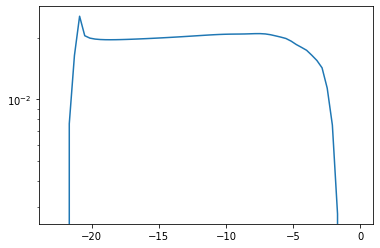

(3.28303305795652, -4.778754780005075, 0.01853621826693345, 1.0000000000000002)


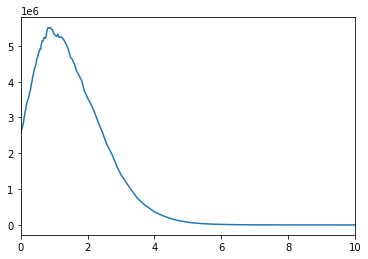

In [981]:
Average_SF_mass_needed = 0.13123123123
nformed = np.sum(Sim_SFRD2, axis=1) / Average_SF_mass_needed
metallicities = Sim_center_Zbin
Sim_metals = Metals
Sim_redshifts = Redshifts
n_binaries = 1
COMPAS_metallicities = [1e-2]
z_of_formation = 3.3
formation_rate = np.zeros(shape=(n_binaries, len(Redshifts)))

print(calc_dPdlogZ(z_of_formation, Sim_redshifts, COMPAS_metallicities[0], metallicities, Sim_metals))

for i in range(n_binaries):
    if len(Sim_metals) > 0:
        formation_rate[i, :] = nformed * calc_dPdlogZ_v2(z_of_formation, Sim_redshifts, COMPAS_metallicities[i], \
        metallicities, Sim_metals, showdist=False)[2] #/ p_draw_metallicity * COMPAS_weights[i]
        plt.plot(Sim_redshifts, formation_rate[i])
        plt.xlim(0, 10)
    #else:
        # calculate formation rate (see Neijssel+19 Section 4) - note this uses dPdlogZ for *closest* metallicity
        #formation_rate[i, :] = n_formed * dPdlogZ[:, np.digitize(COMPAS_metallicites[i], metallicities)] 
        #/ p_draw_metallicity * COMPAS_weights[i]

In [974]:
3.28303305795652, 0.008406460345289805, 0.0016591441345033165, 0.9999999999999996

(3.28303305795652,
 0.008406460345289805,
 0.0016591441345033165,
 0.9999999999999996)

In [975]:
sfr2 = find_sfr(redshift_new, a=sf_a, b=sf_b, c=sf_c, d=sf_d)

dPdlogZ1, metallicities1, step_logZ1, p_draw_metallicity1 = find_metallicity_distribution(redshift_new, metals = metals_new,
                                  mu_0=mu0, mu_z=muz, sigma_0=omega0, sigma_z=omegaz, alpha =alpha,
                                  min_logZ=-12.0, max_logZ=0.0, step_logZ =0.01)

In [976]:
dPdlogZ2, metallicities2, step_logZ2, p_draw_metallicity2 = find_metallicity_distribution(Redshifts, metals = metallicities,
                                  mu_0=mu0, mu_z=muz, sigma_0=omega0, sigma_z=omegaz, alpha =alpha,
                                  min_logZ=-12.0, max_logZ=0.0, step_logZ =0.01)

In [977]:
dPdlogZ3, metallicities3, step_logZ3, p_draw_metallicity3 = find_metallicity_distribution(redshift_new,
                                  mu_0=mu0, mu_z=muz, sigma_0=omega0, sigma_z=omegaz, alpha =alpha,
                                  min_logZ=-12.0, max_logZ=0.0, step_logZ =0.01)

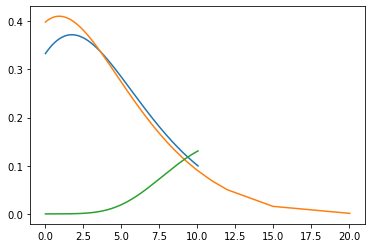

In [978]:
plt.plot(redshift_new, dPdlogZ1[:, np.digitize(COMPAS_metallicities[0], metals_new)]);
plt.plot(Redshifts, dPdlogZ2[:, np.digitize(COMPAS_metallicities[0], metallicities)]);
plt.plot(redshift_new, dPdlogZ3[:, np.digitize(COMPAS_metallicities[0], metals_new)]);

In [869]:
dpdlogZ_model = dPdlogZ[:, np.digitize(COMPAS_metallicities[0], metals_new)]
dpdlogZ_model.shape

(202,)

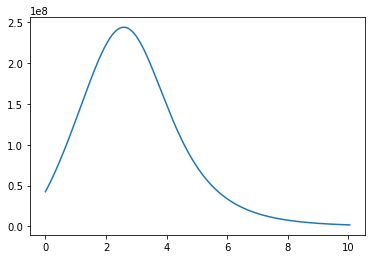

In [861]:
model_form_rate = np.zeros(shape=(n_binaries, len(redshift_new)))
model_form_rate[0, :] = sfr2/Average_SF_mass_needed * dPdlogZ[:, np.digitize(COMPAS_metallicities[0], metals_new)]
plt.plot(redshift_new, model_form_rate[0])

In [814]:
metallicities

array([1.23389963e-10, 1.81111698e-10, 2.65835618e-10, 3.90193325e-10,
       5.72725476e-10, 8.40646035e-10, 1.23389963e-09, 1.81111698e-09,
       2.65835618e-09, 3.90193325e-09, 5.72725476e-09, 8.40646035e-09,
       1.23389963e-08, 1.81111698e-08, 2.65835618e-08, 3.90193325e-08,
       5.72725476e-08, 8.40646035e-08, 1.23389963e-07, 1.81111698e-07,
       2.65835618e-07, 3.90193325e-07, 5.72725476e-07, 8.40646035e-07,
       1.23389963e-06, 1.81111698e-06, 2.65835618e-06, 3.90193325e-06,
       5.72725476e-06, 8.40646035e-06, 1.23389963e-05, 1.81111698e-05,
       2.65835618e-05, 3.90193325e-05, 5.72725476e-05, 8.40646035e-05,
       1.23389963e-04, 1.81111698e-04, 2.65835618e-04, 3.90193325e-04,
       5.72725476e-04, 8.40646035e-04, 1.23389963e-03, 1.81111698e-03,
       2.65835618e-03, 3.90193325e-03, 5.72725476e-03, 8.40646035e-03,
       1.23389963e-02, 1.81111698e-02, 2.65835618e-02, 3.90193325e-02,
       5.72725476e-02, 8.40646035e-02, 1.23389963e-01, 1.81111698e-01,
      

In [704]:
formation_rate

array([[3.25177065e+06, 1.43814494e+08, 8.41071356e+08, 1.30778775e+09,
        1.86712253e+09, 2.27256206e+09, 2.56736678e+09, 2.98789341e+09,
        3.38277266e+09, 3.87347717e+09, 4.34634488e+09, 4.71512104e+09,
        5.70140324e+09, 7.07832220e+09, 7.36259503e+09, 8.34285250e+09,
        9.29506962e+09, 1.02569346e+10, 1.18089721e+10, 1.29656875e+10,
        1.35589674e+10, 1.39969836e+10, 1.46766914e+10, 1.47919540e+10,
        1.51919466e+10, 1.45437363e+10, 1.42209509e+10, 1.38853474e+10,
        1.25322388e+10, 1.17785302e+10, 1.07973247e+10, 1.01680246e+10,
        9.41800724e+09, 8.68616058e+09, 8.05024822e+09, 7.70953345e+09,
        7.19782868e+09, 6.68868104e+09, 6.40533882e+09, 5.93885288e+09,
        5.67972097e+09, 5.28626388e+09, 4.94970497e+09, 4.62379578e+09,
        4.30925767e+09, 4.03848391e+09, 3.68013498e+09, 3.50330737e+09,
        3.23157271e+09, 3.03588901e+09, 2.84140392e+09, 2.66084053e+09,
        2.53126116e+09, 2.38525993e+09, 2.21266932e+09, 2.071978

## dPdlogZ issues

1. dPdlogZ vs dPdZ
    - From what I understand: since the metallicity bins are spaced out in logspace (np.logspace = base log10!! make sure consistent later too, this feels like a possible source of issue), this means that the metallicity distributions are already logZ (again note base 10 vs base e)
    - This means that when evaluating dPdlogZ, I need the logZ of the COMPAS binary metallicity, and logZ of the centers of the redshift bins in the TNG data (Sim_center_Zbin). Then at the associated redshift, the metallicity distribution should alreay be in logZ, so find probability of getting the closest log(Sim_center_Zbin) to the log(COMPAS binary metallicity) in that metallicity distribution. 
    - Expected result: same approximate shape and same order of magnitude of the merger rate as when using the model dPdlogZ
    - However, merger rates are currently 1-2 orders of magnitude lower than what I get from the model. The discrepancy is worse when using the (more likely correct) dPdlogZ version in which I do not take the log of the metallicity distribution (e.g. histogram) values
    

2. Evaluate dPdlogZ at all redshifts, not at formation redshift
    - calc_dPdlogZ vs calc_dPdlogZ_v2, original evaluates it specifically at the formation redshift of the binary. However, it looks like in COMPAS cosmic integration, it evaluates dPdlogZ for all redshifts for that binary (finds the probability of getting that binary metallicity at all redshifts?), which is then convolved with the SFR
    - Expected result: 1D array of dPdlogZ values, for which v2 is needed
    

3. Is the model cosmic integration version even correct?
    - When fitting the model to the TNG data, dPdlogZ is calculated for the array of metallicities (Sim_center_Zbin). In COMPAS cosmic integration, there is no option to put in an array of metallicities; instead it calculates the metallicity range ***USING NP.ARANGE*** between **NATURAL** log(min Z) and log(max Z). From the TNG data, the bins were calculated using np.logspace which uses log base 10. 
    - When trying to calculate it both ways in this notebook, the plot of dPdlogZ has a **completely different shape** when calculated using an input array of metallicities vs creating one from a min, max, and step. Not sure if something is going wrong where I'm doing it in this notebook or these actually produce different things vs the logs issue
    - Likely need to check what dPdlogZ looks like when running actual cosmic integration, to see what I expect here
    - Source of concern: if the dPdlogZ which is fitted to the data is a completely different shape from the dPdlogZ which cosmic integration uses to calculate the merger rates, can we even trust the output of cosmic integration? Is it even using the model correctly? To check this, probably a good idea to plot dPdlogZ **and** calculate and plot SFRD(Z, z) in cosmic integration. 